In [1]:
%ls data

archive.zip                            olist_orders_dataset.csv
olist_customers_dataset.csv            olist_products_dataset.csv
olist_geolocation_dataset.csv          olist_products_dataset_po.csv
olist_order_items_dataset.csv          olist_sellers_dataset.csv
olist_order_payments_dataset.csv       product_category_name_translation.csv
olist_order_reviews_dataset.csv


In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime

In [3]:
geo_data = pd.read_csv('data/olist_geolocation_dataset.csv')
order_data = pd.read_csv('data/olist_orders_dataset.csv')
order_item_data = pd.read_csv('data/olist_order_items_dataset.csv')
products_data = pd.read_csv('data/olist_products_dataset.csv')
sellers_data = pd.read_csv('data/olist_sellers_dataset.csv')
payment_data = pd.read_csv('data/olist_order_payments_dataset.csv')

## diff_days

### 결측값 채우기

In [4]:
order_data.isnull().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

**결측값의 비율은 약 3%이므로 'order_delivered_customer_date'의 Null 값은 'order_estimated_delivery_date'로 채우기**

In [5]:
## **결측값의 비율은 약 3%이므로 고객 날짜 기능의 Null 값은 forward-fill method로 채우기**
# order_data['order_delivered_customer_date']= order_data['order_delivered_customer_date'].fillna(method='ffill')
# order_data['order_delivered_customer_date'].isnull().sum()

In [6]:
order_data['order_delivered_customer_date']= order_data['order_delivered_customer_date'].fillna(order_data['order_estimated_delivery_date'])
order_data['order_delivered_customer_date'].isnull().sum()

0

### 날짜 컬럼 생성

**배송 완료 날짜 및 예상 날짜 컬럼 생성**

In [7]:
order_data['delivered_time']=pd.to_datetime(order_data['order_delivered_customer_date'],
                                            format='%Y-%m-%d').dt.date
order_data['estimate_time']=pd.to_datetime(order_data['order_estimated_delivery_date'], 
                                           format='%Y-%m-%d').dt.date

**주문 배송된 고객 날짜를 기준으로 Weekly 생성**

In [8]:
order_data['weekly']=pd.to_datetime(order_data['order_delivered_customer_date'],
                                    format='%Y-%m-%d').dt.week

<ipython-input-8-7141a3e5f4d0>:1: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  order_data['weekly']=pd.to_datetime(order_data['order_delivered_customer_date'],


**주문 배송된 고객 날짜를 기반으로 Monthly 생성**

In [9]:
order_data['monthly']=pd.to_datetime(order_data['order_delivered_customer_date'])\
                    .dt.to_period('M')
order_data['monthly']= order_data['monthly'].astype(str)

### diff_days 생성

**예상 날짜와 배송된 날짜의 차이로 diff_days 생성**

In [10]:
order_data['diff_days']= order_data['delivered_time']-order_data['estimate_time']
order_data['diff_days']= order_data['diff_days'].dt.days

In [11]:
# 배송완료된 주문제품만
order_data_delivery = order_data[order_data["order_status"]=='delivered']

In [12]:
# 배송완료 예정 날짜보다 늦게 배송된 경우
order_data_delivery[order_data_delivery['diff_days']>0].shape

(6534, 13)

In [13]:
# 배송완료 예정 날짜 = 실제 배송완료 날짜
order_data_delivery[order_data_delivery['diff_days']==0].shape

(1300, 13)

In [14]:
# 배송완료 예정 날짜보다 빨리 배송된 경우
order_data_delivery[order_data_delivery['diff_days']<0].shape

(88644, 13)

In [15]:
order_data_delivery.head(2)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,delivered_time,estimate_time,weekly,monthly,diff_days
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,2017-10-10,2017-10-18,41,2017-10,-8
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,2018-08-07,2018-08-13,32,2018-08,-6


### weekly diff_days

In [16]:
order_data_delivery.groupby(['weekly'])["diff_days"].mean()

weekly
1     -9.179291
2    -11.274967
3    -13.562369
4    -14.163656
5    -15.182986
6    -16.203322
7    -15.799630
8    -13.617605
9    -11.401540
10   -10.357715
11    -9.141724
12    -8.606580
13    -9.058068
14    -7.699257
15    -8.748567
16    -9.904279
17   -11.989136
18   -11.790677
19   -11.844112
20   -11.816672
21   -11.213804
22   -11.815772
23   -13.277978
24   -18.280579
25   -16.657393
26   -16.180823
27   -15.812530
28   -14.131258
29   -12.202691
30   -11.657437
31   -11.331565
32    -9.960604
33    -8.816615
34   -10.163465
35   -10.815978
36   -11.667949
37   -10.772212
38    -5.782814
39   -11.297828
40   -13.302050
41   -15.554979
42   -13.951473
43   -13.352159
44   -12.252772
45   -11.619243
46   -10.698646
47   -10.564319
48   -10.555990
49   -11.439655
50   -11.378305
51   -10.894824
52   -11.250749
Name: diff_days, dtype: float64

Text(0.5, 1.0, 'Average Difference Days per Week')

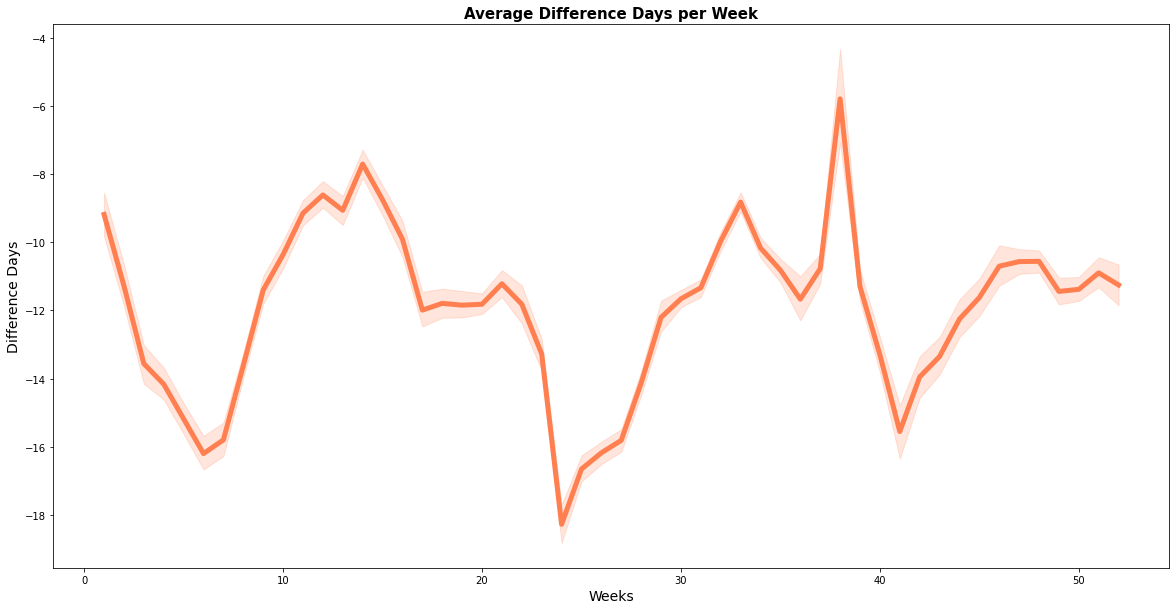

In [17]:
plt.figure(figsize=(20,10))
sns.lineplot(x='weekly', y='diff_days', data=order_data_delivery, color="coral", linewidth=5,
            markers=True,dashes=False, estimator='mean')

plt.xlabel("Weeks", size=14)
plt.ylabel("Difference Days", size=14)
plt.title("Average Difference Days per Week",size=15, weight='bold')

### monthly diff_days

In [18]:
order_data_delivery.groupby(['monthly'])["diff_days"].mean()

monthly
2016-10   -41.434146
2016-11   -20.379310
2016-12    -7.250000
2017-01   -30.056537
2017-02   -25.159141
2017-03   -14.372796
2017-04   -14.546241
2017-05   -12.490269
2017-06   -13.530397
2017-07   -12.523300
2017-08   -13.255463
2017-09   -10.343001
2017-10   -12.648865
2017-11   -10.765310
2017-12   -11.242992
2018-01   -11.997878
2018-02   -12.132479
2018-03    -7.889215
2018-04    -8.353758
2018-05   -11.275489
2018-06   -16.790630
2018-07   -13.676762
2018-08    -8.372865
2018-09    22.553571
2018-10    83.666667
Name: diff_days, dtype: float64

Text(0.5, 1.0, 'Average Difference Days per Month')

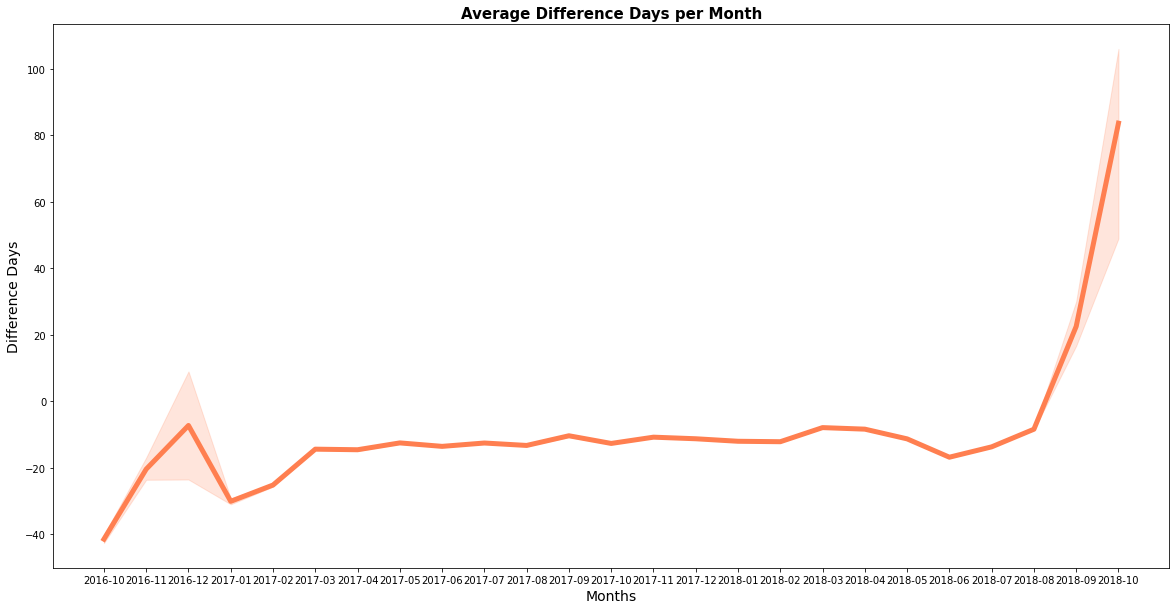

In [19]:
order_data_delivery1 = order_data_delivery
order_data_delivery1 = order_data_delivery.sort_values('monthly')

plt.figure(figsize=(20,10))
sns.lineplot(x='monthly', y='diff_days', data=order_data_delivery1, color="coral", linewidth=5,
            markers=True,dashes=False,estimator='mean')

plt.xlabel("Months", size=14)
plt.ylabel("Difference Days", size=14)
plt.title("Average Difference Days per Month",size=15, weight='bold')

### seller/category 별 diff_days

**배송예상날짜와 배송완료날짜 차이를 판매자와 카테고리별로 보기 위해**

In [20]:
df_orders = pd.merge(order_data, order_item_data, on="order_id",how = 'right')

In [21]:
df_orders = pd.merge(df_orders, products_data, on="product_id",how = 'right')

In [22]:
df_orders = df_orders.drop_duplicates(['order_id','product_id'], keep = 'first')

In [23]:
df_orders[df_orders.duplicated(['order_id','product_id'])]

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,delivered_time,estimate_time,...,freight_value,product_category_name,product_category_name_port,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm


In [24]:
# 배송완료된 주문 제품만
df_orders_delivery = df_orders[df_orders["order_status"]=='delivered']

#### seller > diff_days

**seller별 배송예상날짜와 실제배송날짜 차이 평균**

In [25]:
df_orders_delivery.groupby(['seller_id'])["diff_days"].mean().sort_values()

seller_id
933446e9a59dece7ae9175103820ca8f    -66.0
0b09101900100c0e9d312861fad5a1b9    -61.0
fa5fdc4e4bb6bd1009ad0e4ac4096562    -58.0
ffff564a4f9085cd26170f4732393726    -48.0
58e4b302b54937e55a678c4d15111da4    -48.0
                                    ...  
6f1a1263039c76e68f40a8e536b1da6a     31.0
8629a7efec1aab257e58cda559f03ba7     33.0
4fb41dff7c50136976d1a5cf004a42e2     33.0
8e670472e453ba34a379331513d6aab1     35.0
df683dfda87bf71ac3fc63063fba369d    167.0
Name: diff_days, Length: 2970, dtype: float64

#### category > diff_days

**카테고리별 배송예상날짜와 실제배송날짜 차이 평균**

In [26]:
df_orders.groupby(['product_category_name'])["diff_days"].mean().sort_values()

product_category_name
security_and_services               -17.000000
la_cuisine                          -16.384615
cds_dvds_musicals                   -15.833333
fixed_telephony                     -14.562212
fashion_shoes                       -14.521236
                                       ...    
home_confort                         -9.679803
food                                 -9.626932
home_comfort_2                       -8.708333
furniture_mattress_and_upholstery    -6.973684
arts_and_craftmanship                -6.791667
Name: diff_days, Length: 71, dtype: float64

In [27]:
df_orders_delivery['diff_days'].sort_values()

84882    -147
103127   -140
20985    -135
87161    -124
59215    -109
         ... 
36542     166
95255     167
110636    175
1466      181
86906     188
Name: diff_days, Length: 100196, dtype: int64

Text(0.5, 1.0, 'Average Difference Days per Category')

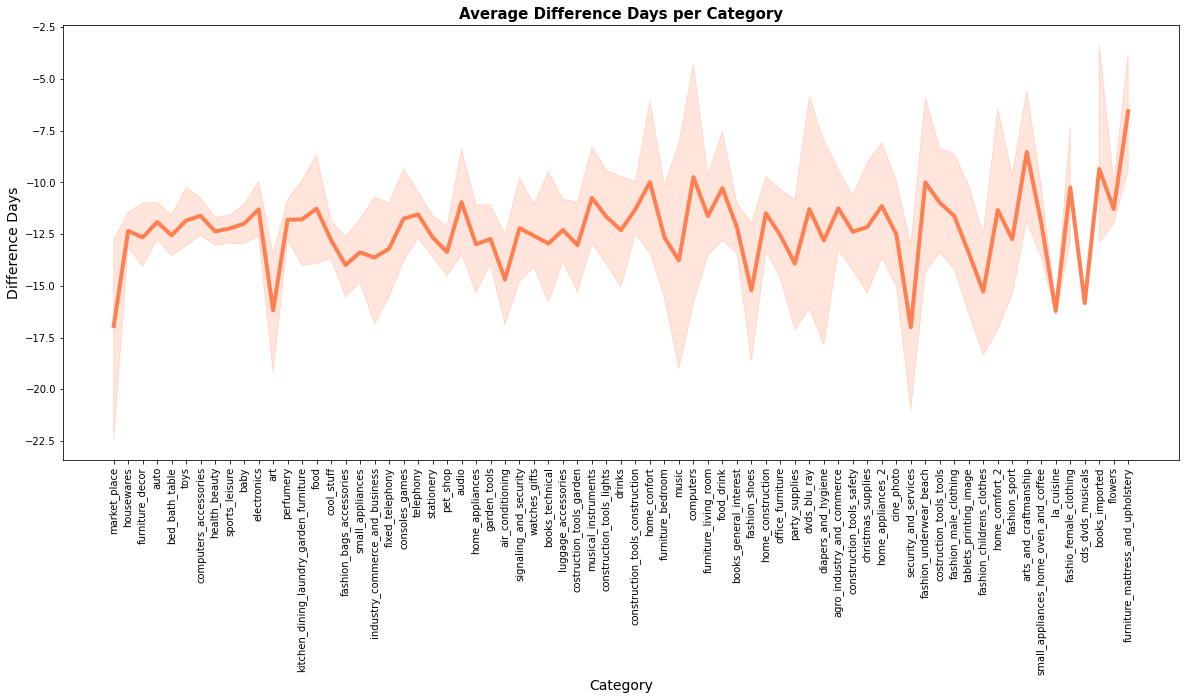

In [30]:
df_agg1 = df_agg
df_agg1 = df_agg.sort_values('diff_days')

plt.figure(figsize=(20,8))
sns.lineplot(x='product_category_name', y='diff_days', data=df_agg1, color="coral", linewidth=4,
            markers=True,dashes=False,estimator='mean')
plt.xticks(rotation=90)
plt.xlabel("Category", size=14)
plt.ylabel("Difference Days", size=14)
plt.title("Average Difference Days per Category",size=15, weight='bold')

#### category > seller > diff_days

**카테고리별 셀러의 배송예상날짜와 실제배송날짜 차이 평균 순위**

In [29]:
# 첫 번째 그룹바이
df_agg = df_orders_delivery.groupby(['product_category_name','seller_id']).agg({'diff_days':'mean'})
df_agg

diff_days
product_category_name      seller_id                                  
agro_industry_and_commerce 06579cb253ecd5a3a12a9e6eb6bf8f47 -10.000000
                           0ed6ce5d87fd9c69eaacaeb778d67235  -9.000000
                           2528744c5ef5d955adc318720a94d2e7  -9.400000
                           269cff2d3c8d205c11f37a52402ea93b  -9.000000
                           31ae0774c17fabd06ff707cc5bde005f -12.857143
...                                                                ...
watches_gifts              f8db351d8c4c4c22c6835c19a46f01b0 -11.200000
                           f9eedec3129e8cc6b6429c42d0808c5b  -9.000000
                           fa1c13f2614d7b5c4749cbc52fecda94 -10.309441
                           fcba71d4d5db057f43249145e4eb1e27  -7.666667
                           ffc470761de7d0232558ba5e786e57b7 -13.400000

[6144 rows x 1 columns]

In [31]:
# 인덱스의 첫 번째 수준으로 그룹화
g = df_agg['diff_days'].groupby(level=0, group_keys=False)

In [32]:
# 각 그룹 내에서 diff_days 열을 내림차순으로 정렬하고 상위 3 개 행만 가져오기
#delivery_ = g.apply(lambda x: x.order(ascending=False).head(3))
delivery_fast = g.apply(lambda x: x.sort_values(ascending=False).tail(3))
delivery_fast

product_category_name       seller_id                       
agro_industry_and_commerce  6b2612338467c08c9b25f0cc55b1578d   -22.000000
                            85cc55e048b6bcc90c75afe7f0e72f72   -23.000000
                            55bb6fe5bebe5012e2d7d9928e1128ff   -24.000000
air_conditioning            ac6417315ae5da8f9a38ee11de6f7780   -28.000000
                            c7dcd301ecfe5ab7f778ac172cf74be7   -29.000000
                                                                  ...    
toys                        e883aa812c37a7413226856f4579fe91   -37.000000
                            4bde6149c15cf7e177b36fa060dd6de8   -52.000000
watches_gifts               710e3548e02bc1d2831dfc4f1b5b14d4   -29.666667
                            747e73c01a4593d4cf60dcf970fd2689   -30.000000
                            9f505651f4a6abe901a56cdc21508025   -33.333333
Name: diff_days, Length: 209, dtype: float64

In [33]:
delivery_slow = g.apply(lambda x: x.sort_values(ascending=False).head(3))
delivery_slow

product_category_name       seller_id                       
agro_industry_and_commerce  3d0cd21d41671c46f82cd11176bf7277    -2.000000
                            397c4d0c005b6f41f90098ac724e28cb    -3.000000
                            6bd69102ab48df500790a8cecfc285c2    -3.600000
air_conditioning            15aac934c58d886785ac1b17953ea898     4.666667
                            b2ba3715d723d245138f291a6fe42594    -2.000000
                                                                  ...    
toys                        4c8b8048e33af2bf94f2eb547746a916    12.000000
                            bdb3edbaee43a761e2d4f258dc08f348     7.000000
watches_gifts               4fb41dff7c50136976d1a5cf004a42e2    33.000000
                            e7df4cd29ab5abab70fb0783ddb53987     6.000000
                            e82de6494d91d3c4c54450f59b227a94     3.000000
Name: diff_days, Length: 209, dtype: float64

In [34]:
# 한번에 보기
df_orders_delivery.groupby(['product_category_name']).apply(lambda x: (x.groupby('seller_id')
                                      .mean()
                                      .sort_values('diff_days', ascending=False))
                                     .tail(3))

weekly  \
product_category_name      seller_id                                     
agro_industry_and_commerce 6b2612338467c08c9b25f0cc55b1578d   9.000000   
                           85cc55e048b6bcc90c75afe7f0e72f72  31.000000   
                           55bb6fe5bebe5012e2d7d9928e1128ff  22.500000   
air_conditioning           ac6417315ae5da8f9a38ee11de6f7780  19.000000   
                           c7dcd301ecfe5ab7f778ac172cf74be7  43.000000   
...                                                                ...   
toys                       e883aa812c37a7413226856f4579fe91  34.000000   
                           4bde6149c15cf7e177b36fa060dd6de8  41.000000   
watches_gifts              710e3548e02bc1d2831dfc4f1b5b14d4  34.000000   
                           747e73c01a4593d4cf60dcf970fd2689  14.333333   
                           9f505651f4a6abe901a56cdc21508025  21.666667   

                                                             diff_days  \
product_category_name      seller_id                                     
agro_industry_and_commerce 6b2612338467c08c9b25f0cc55b1578d -22.000000   
                           85cc55e048b6bcc90c75afe7f0e72f72 -23.000000   
                           55bb6fe5bebe5012e2d7d9928e1128ff -24.000000   
air_conditioning           ac6417315ae5da8f9a38ee11de6f7780 -28.000000   
                           c7dcd301ecfe5ab7f778ac172cf74be7 -29.000000   
...                                                                ...   
toys                       e883aa812c37a7413226856f4579fe91 -37.000000   
                           4bde6149c15cf7e177b36fa060dd6de8 -52.000000   
watches_gifts              710e3548e02bc1d2831dfc4f1b5b14d4 -29.666667   
                           747e73c01a4593d4cf60dcf970fd2689 -30.000000   
                           9f505651f4a6abe901a56cdc21508025 -33.333333   

                                                             order_item_id  \
product_category_name      seller_id                                         
agro_industry_and_commerce 6b2612338467c08c9b25f0cc55b1578d            1.0   
                           85cc55e048b6bcc90c75afe7f0e72f72            1.0   
                           55bb6fe5bebe5012e2d7d9928e1128ff            1.0   
air_conditioning           ac6417315ae5da8f9a38ee11de6f7780            1.0   
                           c7dcd301ecfe5ab7f778ac172cf74be7            1.0   
...                                                                    ...   
toys                       e883aa812c37a7413226856f4579fe91            1.0   
                           4bde6149c15cf7e177b36fa060dd6de8            1.0   
watches_gifts              710e3548e02bc1d2831dfc4f1b5b14d4            1.0   
                           747e73c01a4593d4cf60dcf970fd2689            1.0   
                           9f505651f4a6abe901a56cdc21508025            1.0   

                                                                  price  \
product_category_name      seller_id                                      
agro_industry_and_commerce 6b2612338467c08c9b25f0cc55b1578d   92.900000   
                           85cc55e048b6bcc90c75afe7f0e72f72   33.900000   
                           55bb6fe5bebe5012e2d7d9928e1128ff   98.500000   
air_conditioning           ac6417315ae5da8f9a38ee11de6f7780  110.300000   
                           c7dcd301ecfe5ab7f778ac172cf74be7  299.990000   
...                                                                 ...   
toys                       e883aa812c37a7413226856f4579fe91   59.900000   
                           4bde6149c15cf7e177b36fa060dd6de8   79.900000   
watches_gifts              710e3548e02bc1d2831dfc4f1b5b14d4  149.990000   
                           747e73c01a4593d4cf60dcf970fd2689  739.330000   
                           9f505651f4a6abe901a56cdc21508025   21.656667   

                                                             freight_value  \
product_category_name      seller_id                                 

In [35]:
# 카테고리 종류 보기
df_orders_delivery['product_category_name'].unique().tolist()

['perfumery',
 'art',
 'sports_leisure',
 'baby',
 'housewares',
 'musical_instruments',
 'cool_stuff',
 'furniture_decor',
 'home_appliances',
 'toys',
 'bed_bath_table',
 'construction_tools_safety',
 'computers_accessories',
 'health_beauty',
 'luggage_accessories',
 'garden_tools',
 'office_furniture',
 'auto',
 'electronics',
 'fashion_shoes',
 'telephony',
 'stationery',
 'fashion_bags_accessories',
 'computers',
 'home_construction',
 'watches_gifts',
 'construction_tools_construction',
 'pet_shop',
 'small_appliances',
 'agro_industry_and_commerce',
 nan,
 'furniture_living_room',
 'signaling_and_security',
 'air_conditioning',
 'consoles_games',
 'books_general_interest',
 'costruction_tools_tools',
 'fashion_underwear_beach',
 'fashion_male_clothing',
 'kitchen_dining_laundry_garden_furniture',
 'industry_commerce_and_business',
 'fixed_telephony',
 'construction_tools_lights',
 'books_technical',
 'home_appliances_2',
 'party_supplies',
 'drinks',
 'market_place',
 'la_cuisi

## Top 10

In [45]:
#Merge data
total_orders=pd.merge(order_data, order_item_data)
product_orders=pd.merge(total_orders,products_data, on="product_id")
product_orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112650 entries, 0 to 112649
Data columns (total 28 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       112650 non-null  object 
 1   customer_id                    112650 non-null  object 
 2   order_status                   112650 non-null  object 
 3   order_purchase_timestamp       112650 non-null  object 
 4   order_approved_at              112635 non-null  object 
 5   order_delivered_carrier_date   111456 non-null  object 
 6   order_delivered_customer_date  112650 non-null  object 
 7   order_estimated_delivery_date  112650 non-null  object 
 8   delivered_time                 112650 non-null  object 
 9   estimate_time                  112650 non-null  object 
 10  weekly                         112650 non-null  int64  
 11  monthly                        112650 non-null  object 
 12  diff_days                     

### Top 10 Product

**product_id 값 이름 줄이기**
- 마지막 8자만 가져오기 (고유성이 유지되는지 확인)

In [46]:
len(product_orders['product_id'].unique())

32951

In [47]:
len(product_orders['product_id'].str[-8:].unique())

32951

In [48]:
product_orders['product_id_shorten']=product_orders['product_id'].str[-8:]

Text(0.5, 1.0, 'Top 10 Products')

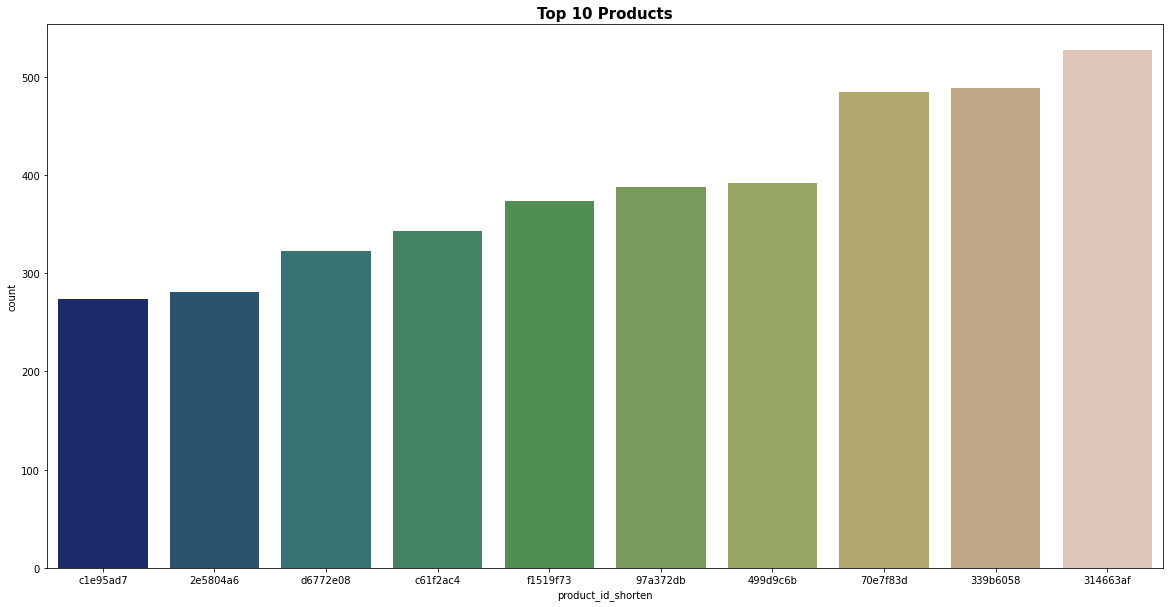

In [49]:
#Plotting Top 10 Products
plt.figure(figsize=(20,10))
sns.countplot(x='product_id_shorten', data=product_orders, palette='gist_earth',
             order=product_orders['product_id_shorten'].value_counts()[:10]\
             .sort_values().index).set_title("Top 10 Products", fontsize=15,
                                             weight='bold')

**Top 10 Product의 카테고리**

In [50]:
group_category= product_orders.groupby(['product_id_shorten','product_category_name',])['product_id_shorten']\
                                        .count().sort_values(ascending=False).head(10)
group_category

product_id_shorten  product_category_name
314663af            furniture_decor          527
339b6058            bed_bath_table           488
70e7f83d            garden_tools             484
499d9c6b            garden_tools             392
97a372db            garden_tools             388
f1519f73            garden_tools             373
c61f2ac4            computers_accessories    343
d6772e08            watches_gifts            323
2e5804a6            health_beauty            281
c1e95ad7            computers_accessories    274
Name: product_id_shorten, dtype: int64

### Top 10 Category

In [51]:
product_orders.groupby(["product_category_name"])["product_id_shorten"].count().sort_values(ascending=False).head(10)

product_category_name
bed_bath_table           11115
health_beauty             9670
sports_leisure            8641
furniture_decor           8334
computers_accessories     7827
housewares                6964
watches_gifts             5991
telephony                 4545
garden_tools              4347
auto                      4235
Name: product_id_shorten, dtype: int64

### Top 10 Seller

In [52]:
#First seller dataset will be merged with the product orders data.
seller_products = pd.merge(product_orders, sellers_data, on="seller_id")
seller_products.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112650 entries, 0 to 112649
Data columns (total 32 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       112650 non-null  object 
 1   customer_id                    112650 non-null  object 
 2   order_status                   112650 non-null  object 
 3   order_purchase_timestamp       112650 non-null  object 
 4   order_approved_at              112635 non-null  object 
 5   order_delivered_carrier_date   111456 non-null  object 
 6   order_delivered_customer_date  112650 non-null  object 
 7   order_estimated_delivery_date  112650 non-null  object 
 8   delivered_time                 112650 non-null  object 
 9   estimate_time                  112650 non-null  object 
 10  weekly                         112650 non-null  int64  
 11  monthly                        112650 non-null  object 
 12  diff_days                     

**seller id 길이 줄이기**
- 마지막 6자만 가져오기 (고유성이 유지되는지 확인)

In [54]:
len(seller_products['seller_id'].unique())

3095

In [55]:
len(seller_products['seller_id'].str[-6:].unique())

3095

In [56]:
seller_products['seller_id_shorten']=seller_products['seller_id'].str[-6:]

In [79]:
seller_products.groupby(['seller_id_shorten'])['seller_id_shorten'].count().sort_values(ascending=False).head(10)

seller_id_shorten
7e94c0    2033
493884    1987
523100    1931
b7556a    1775
dab84a    1551
80ce60    1499
0e0bfa    1428
b010ab    1364
f13abc    1203
3ad736    1171
Name: seller_id_shorten, dtype: int64

**Top 10 Seller**
- 상위 3명의 판매자는 비율이 비슷

Text(0.5, 1.0, 'Top 10 Seller')

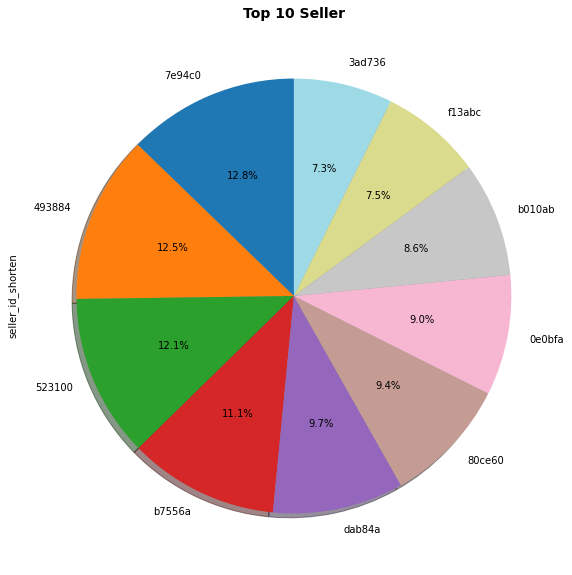

In [58]:
plt.figure(figsize=(20,10))
seller_products['seller_id_shorten'].value_counts()[:10].plot.pie(autopct='%1.1f%%',
        shadow=True, startangle=90, cmap='tab20')
plt.title("Top 10 Seller",size=14, weight='bold')

### seller > category Top 10

In [59]:
seller_category= seller_products.groupby(['seller_id_shorten', 'product_category_name'])\
                        ['seller_id_shorten'].count().sort_values(ascending=False).head(10)
seller_category

seller_id_shorten  product_category_name
523100             garden_tools             1882
7e94c0             watches_gifts            1628
493884             bed_bath_table           1572
0e0bfa             furniture_decor          1292
dab84a             bed_bath_table           1277
b010ab             office_furniture         1233
f13abc             telephony                1178
b7556a             health_beauty            1091
3ad736             cool_stuff               1069
3b52b2             watches_gifts            1002
Name: seller_id_shorten, dtype: int64

In [80]:
# seller_products.groupby(['seller_id_shorten']).apply(lambda x: (x.groupby('product_category_name')
#                                       .count()
#                                       .sort_values('seller_id_shorten', ascending=False))
#                                      .head(3))

### top10 Products  &  top10 Sellers > Category

- 가장 많이 판매되는 제품의 카테고리는 홈 데코레이션 이지만 top seller의 가장 많이 판매되는 카테고리는 정원 도구

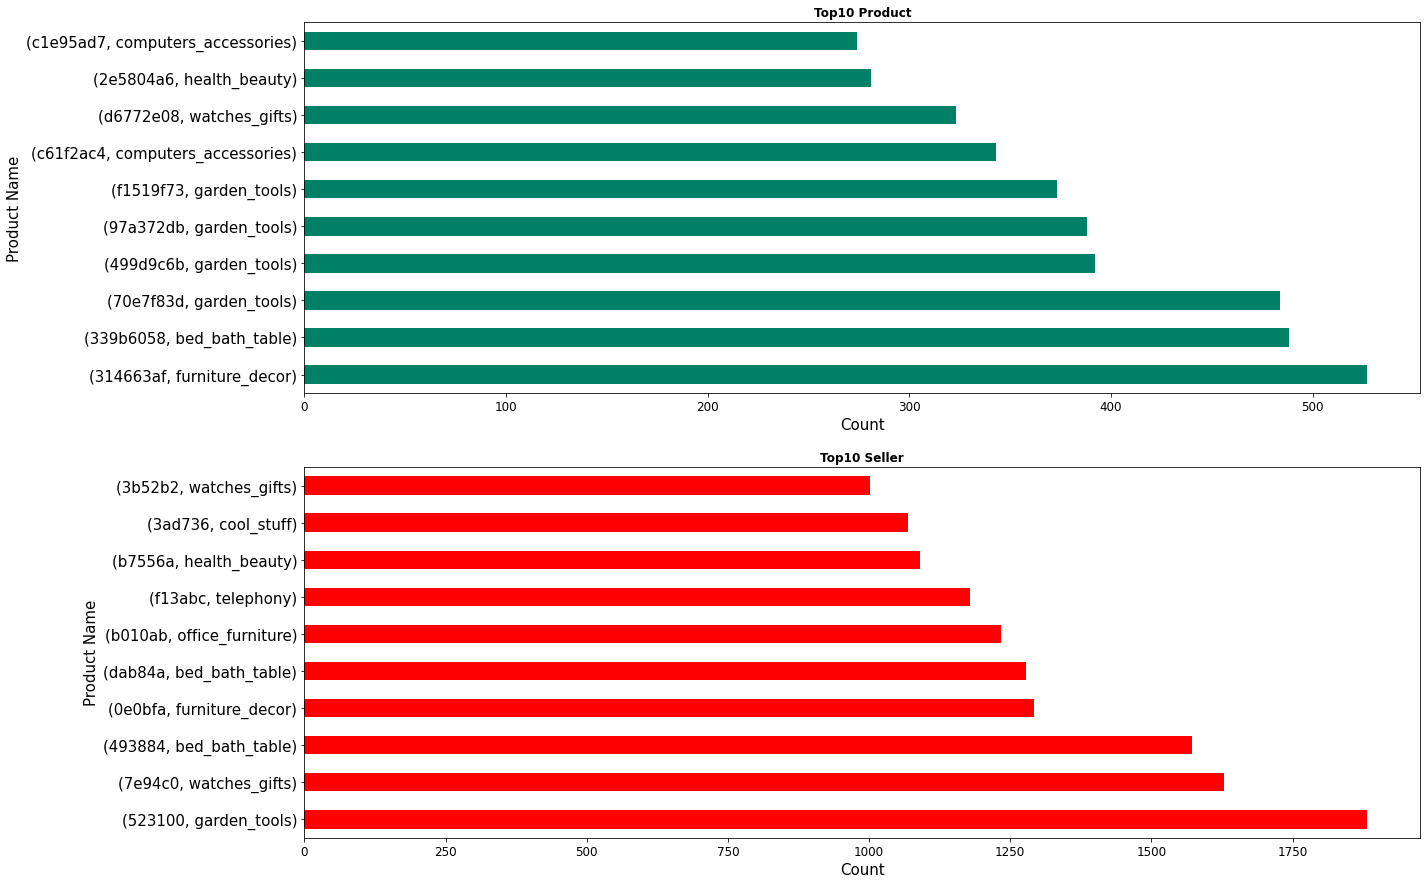

In [81]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(20,15))
group_category.plot.barh(ax=ax1, cmap='summer')
seller_category.plot.barh(ax=ax2, cmap='autumn')

ax1.set_title('Top10 Product', fontweight='bold')
ax2.set_title('Top10 Seller', fontweight='bold')

ax1.set_xlabel('Count', fontsize=15)
ax1.set_ylabel('Product Name', fontsize=15)
ax1.xaxis.set_tick_params(labelsize=12)
ax1.yaxis.set_tick_params(labelsize=15)

ax2.set_xlabel('Count', fontsize=15)
ax2.set_ylabel('Product Name', fontsize=15)
ax2.xaxis.set_tick_params(labelsize=12)
ax2.yaxis.set_tick_params(labelsize=15)

#### 가장 많이 팔린 제품 314663af(홈 데코레이션 카테고리의 제품)의 주간 구매 수량

In [83]:
# First creating new feature of weeks
product_orders['order_week']= pd.to_datetime(product_orders['order_purchase_timestamp'],
                                            format='%Y-%m-%d').dt.isocalendar().week

/Applications/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Weekly Purchased Number of `314663af`')

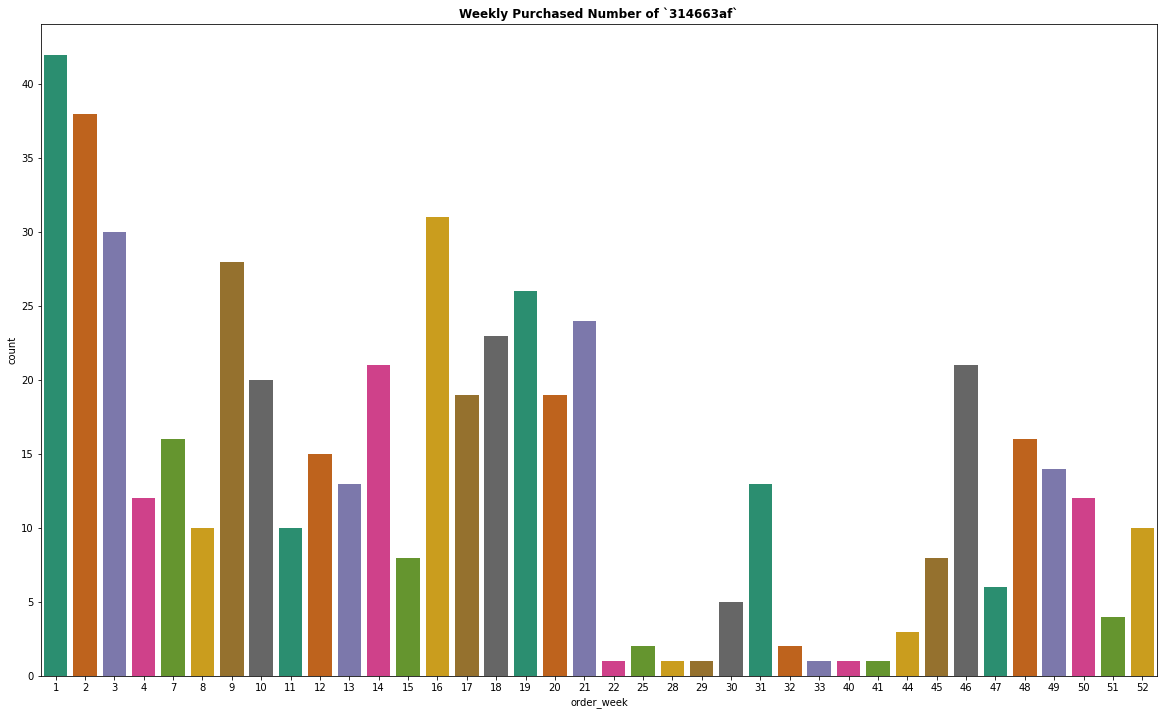

In [84]:
plt.figure(figsize=(20,12))
sns.countplot('order_week', data=product_orders[product_orders['product_id_shorten']== 
                                        '314663af'], palette='Dark2', linewidth=5)\
                                        .set_title('Weekly Purchased Number of `314663af`'
                                                   ,fontweight='bold')

- 314663af의 주간 구매 수량
- 가장 적게 구매한 달은 6월과 8월

#### 가장 많이 팔린 제품 314663af(홈 데코레이션 카테고리의 제품)의 월간 구매 수량

In [85]:
product_orders['order_month']=pd.to_datetime(product_orders['order_purchase_timestamp'])\
                    .dt.to_period('M')
product_orders['order_month']= product_orders['order_month'].astype(str)

/Applications/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Monthly Purchased Number of `314663af`')

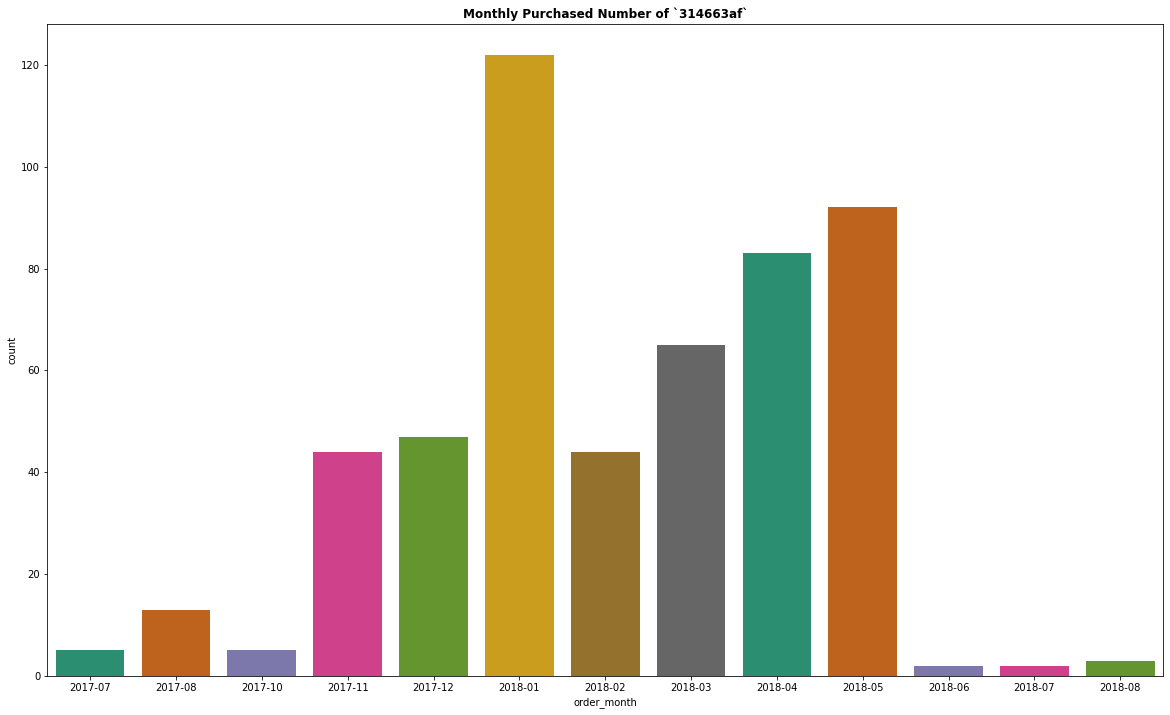

In [86]:
product_orders = product_orders.sort_values('order_month')

plt.figure(figsize=(20,12))
sns.countplot('order_month', data=product_orders[product_orders['product_id_shorten']== 
                                        '314663af'], palette='Dark2', linewidth=5)\
                                        .set_title('Monthly Purchased Number of `314663af`'
                                                   ,fontweight='bold')

#### 주 단위로 가장 많이 팔린 상품 카테고리

In [87]:
#Weekly popular items 
items_weekly =product_orders.groupby(['order_week','product_category_name'])\
                        ['product_category_name'].count().sort_values(ascending=False)
#Change to data frame
most_products= items_weekly.reset_index(name='count')

In [88]:
#Find the max value of row
max_selling_products= most_products[most_products['count'] 
                            == most_products.groupby(['order_week'])\
                            ['count'].transform(max)]
max_selling_products.head(10)

,order_week,product_category_name,count
0,47,bed_bath_table,438
2,33,bed_bath_table,355
3,29,bed_bath_table,339
4,32,health_beauty,330
5,8,computers_accessories,330
8,31,health_beauty,320
9,9,computers_accessories,314
10,19,health_beauty,310
11,18,health_beauty,302
12,23,bed_bath_table,301


In [89]:
max_selling_products['product_category_name'].value_counts()

bed_bath_table           33
health_beauty            10
computers_accessories     3
sports_leisure            3
furniture_decor           2
toys                      1
Name: product_category_name, dtype: int64

- 52주 중 33주 동안 가장 많이 팔린 상품이 bed_table_bath
- 이 카테고리는 가장 많이 판매되는 제품 그룹 또는 가장 많이 판매되는 그룹의 상위 3개에 속함

#### 월 단위로 가장 많이 팔린 상품 카테고리

In [90]:
#Monthly popular items 
items_monthly =product_orders.groupby(['order_month','product_category_name'])\
                        ['product_category_name'].count().sort_values(ascending=False)
#Change to data frame
most_products= items_monthly.reset_index(name='count')

In [91]:
#Find the max value of row
max_selling_products= most_products[most_products['count'] 
                            == most_products.groupby(['order_month'])\
                            ['count'].transform(max)]
max_selling_products.head(10)

,order_month,product_category_name,count
0,2018-02,computers_accessories,981
1,2017-11,bed_bath_table,975
2,2018-06,health_beauty,885
3,2018-08,health_beauty,849
4,2018-01,bed_bath_table,848
5,2018-03,bed_bath_table,798
6,2018-07,health_beauty,784
9,2018-05,health_beauty,770
13,2018-04,bed_bath_table,746
35,2017-07,bed_bath_table,579


In [92]:
max_selling_products['product_category_name'].value_counts()

bed_bath_table                             12
health_beauty                               5
furniture_decor                             4
computers_accessories                       1
fashion_bags_accessories                    1
kitchen_dining_laundry_garden_furniture     1
Name: product_category_name, dtype: int64

## Price

**total_order_value = price + freight_value**

지불 금액(payment value)과 총 주문 금액(total order value)으로 총 이익(Gross Profit)과 이익 마진(Profit Margin)을 계산 가능

In [93]:
payments=pd.merge(seller_products, payment_data, on="order_id")
payments.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 117601 entries, 0 to 117600
Data columns (total 37 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       117601 non-null  object 
 1   customer_id                    117601 non-null  object 
 2   order_status                   117601 non-null  object 
 3   order_purchase_timestamp       117601 non-null  object 
 4   order_approved_at              117586 non-null  object 
 5   order_delivered_carrier_date   116356 non-null  object 
 6   order_delivered_customer_date  117601 non-null  object 
 7   order_estimated_delivery_date  117601 non-null  object 
 8   delivered_time                 117601 non-null  object 
 9   estimate_time                  117601 non-null  object 
 10  weekly                         117601 non-null  int64  
 11  monthly                        117601 non-null  object 
 12  diff_days                     